## Tema: Generación de texto con redes nueornales recurrentes:

## Objetivos:
  
  * Comprender como funcionan las redes RNN
  * Comprender como se genera el texto

## Instrucciones 👍

Ejecutar el siguiente código: puede encontrarlo en su versión original en el enlace https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
PNL desde cero: Generación de nombres con una RNN a nivel de caracteres Autor: Sean Robertson

Este es nuestro segundo de tres tutoriales sobre "NLP From Scratch". En el primer tutorial </intermediate/char_rnn_classification_tutorial> utilizamos una RNN para clasificar nombres en su idioma de origen. En esta ocasión daremos la vuelta y generaremos nombres a partir de idiomas.

::
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py Alemán GER
Gerren
Ereng
Rosher

> python sample.py Español SPA
Salla
Parer
Allan

> python sample.py Chino CHI
Chan
Hang
Iun
Todavía estamos creando a mano una pequeña RNN con unas pocas capas lineales. La gran diferencia es que, en lugar de predecir una categoría tras leer todas las letras de un nombre, introducimos una categoría y emitimos una letra cada vez. La predicción recurrente de caracteres para formar un lenguaje (también podría hacerse con palabras u otras construcciones de orden superior) suele denominarse "modelo de lenguaje".

**Lecturas recomendadas
Asumo que al menos ha instalado PyTorch, sabe Python, y entender Tensores:
https://pytorch.org/ Para instrucciones de instalación
:doc:/beginner/deep_learning_60min_blitz para empezar con PyTorch en general
:doc:/beginner/pytorch_with_examples para una visión amplia y profunda
:doc:/beginner/former_torchies_tutorial si eres un antiguo usuario de Lua Torch
También sería útil saber sobre RNNs y cómo funcionan:
La irrazonable eficacia de las redes neuronales recurrentes_ muestra un montón de ejemplos de la vida real
Entender las redes LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_ trata específicamente de las LSTM, pero también ofrece información sobre las RNN en general. en general
También sugiero el tutorial anterior, :doc:/intermediate/char_rnn_classification_tutorial

## Preparando los Datos

.. Nota:: Descargue los datos de aquí y extráelos al directorio actual.

Ver el último tutorial para más detalles de este proceso. En resumen hay un montón de archivos de texto plano data/names/[Language].txt con un nombre por línea. Dividimos las líneas en un array, convertimos Unicode a ASCII y terminamos con un diccionario {idioma: [nombres ...]}.



In [16]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string


all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path):
  return glob.glob(path)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]



# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines


n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')


print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))


# categories: 18 ['Arabic', 'Chinese', 'Italian', 'Portuguese', 'Greek', 'Japanese', 'English', 'Czech', 'Scottish', 'Spanish', 'Russian', 'Dutch', 'Irish', 'Korean', 'French', 'German', 'Vietnamese', 'Polish']
O'Neal


## Creación de la red

Esta red extiende la RNN del último tutorial_ con un argumento extra para el tensor de categoría, que se concatena junto con los demás. El tensor de categoría es un vector de un solo golpe igual que la entrada de letras.
Interpretaremos la salida como la probabilidad de la siguiente letra. En muestreo, la letra de salida más probable se utiliza como la siguiente letra de letra.
He añadido una segunda capa lineal o2o (después de combinar oculta y salida) para darle más músculo para trabajar. También hay una capa que aleatoriamente ceros partes de su entrada_ con una probabilidad dada (en este caso 0,1) y se suele utilizar para desdibujar las entradas y evitar el sobreajuste. Aquí lo estamos utilizando hacia el final de la red para añadir a propósito algunos caos y aumentar la variedad de muestreo.

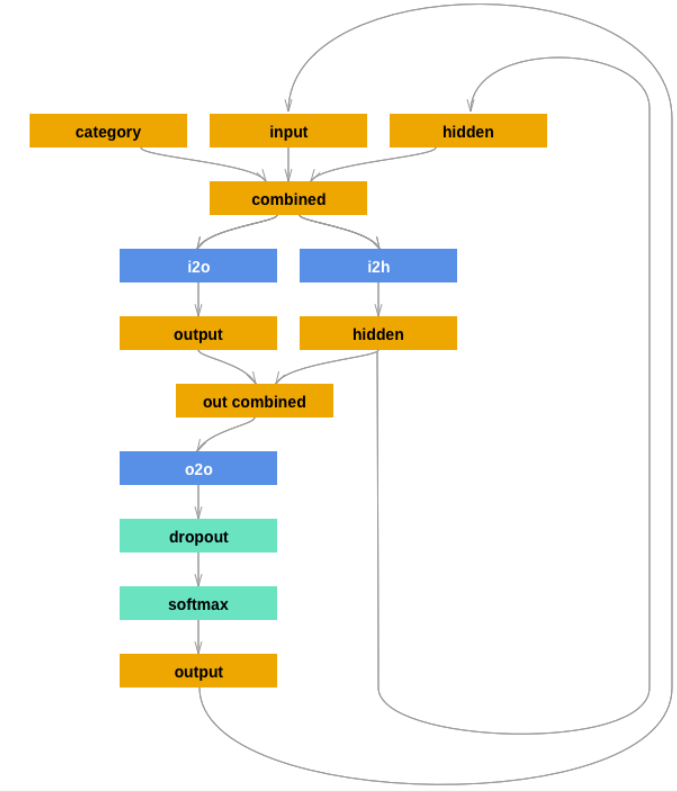

In [12]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size


        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden


    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Entrenamiento

## Preparación para el entrenamiento

En primer lugar, funciones de ayuda para obtener pares aleatorios de (categoría, línea):


In [15]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

Para cada paso de tiempo (es decir, para cada letra de una palabra de entrenamiento) las entradas de la red serán (categoría, letra actual, estado oculto) y las salidas serán (siguiente letra, siguiente estado oculto). Así que para cada conjunto de entrenamiento, necesitaremos categoría, un conjunto de letras de entrada y un conjunto de letras de salida/objetivo. de salida.
Como estamos prediciendo la siguiente letra a partir de la letra actual para cada los pares de letras son grupos de letras consecutivas de la línea. ejemplo, para "ABCD<EOS>" crearíamos ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS").

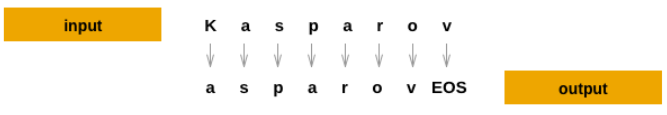

figura:: https://i.imgur.com/JH58tXY.png :alt:
El tensor de categorías es un one-hot tensor_ de tamaño <1 x n_categorías>. Durante el entrenamiento, lo introducimos en la red en cada paso de tiempo. es una elección de diseño, podría haber sido incluido como parte del estado oculto inicial o alguna otra estrategia. de estado oculto inicial o alguna otra estrategia.

In [14]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

Para mayor comodidad durante el entrenamiento crearemos una función randomTrainingExample que obtiene un par aleatorio (categoría, línea) y los convierte en los tensores requeridos (categoría, entrada, objetivo).

In [17]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

##Entrenamiento de la red
A diferencia de la clasificación, en la que sólo se utiliza el último resultado, nosotros estamos haciendo una predicción en cada paso, por lo que estamos calculando la pérdida en en cada paso.
La magia de autograd le permite simplemente sumar estas pérdidas en cada paso y llamar hacia atrás al final.


In [20]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l


    loss.backward()


    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)


    return output, loss.item() / input_line_tensor.size(0)

Para llevar la cuenta de cuánto tiempo lleva el entrenamiento añado una función timeSince(timestamp) que devuelve una cadena legible por humanos:

In [21]:

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

El entrenamiento es como de costumbre - llamar a entrenar un montón de veces y esperar un minutos, imprimiendo el tiempo actual y la pérdida cada print_every ejemplos ejemplos, y mantener la tienda de una pérdida media por plot_every ejemplos en all_losses para graficar más tarde.

In [23]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss


    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))


    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 10s (5000 5%) 2.9116
0m 21s (10000 10%) 2.2918
0m 31s (15000 15%) 2.2977
0m 45s (20000 20%) 2.2782
0m 56s (25000 25%) 2.6943
1m 6s (30000 30%) 2.4022
1m 16s (35000 35%) 2.2754
1m 26s (40000 40%) 2.3786
1m 36s (45000 45%) 1.9381
1m 46s (50000 50%) 3.0410
1m 57s (55000 55%) 2.3949
2m 9s (60000 60%) 3.4490
2m 19s (65000 65%) 1.9955
2m 28s (70000 70%) 3.4204
2m 39s (75000 75%) 2.2741
2m 49s (80000 80%) 2.0287
2m 59s (85000 85%) 3.5137
3m 9s (90000 90%) 2.3017
3m 18s (95000 95%) 2.0455
3m 28s (100000 100%) 3.2014


## Graficar las pérdidas
Graficar la pérdida histórica de all_losses muestra que la red aprendiendo:


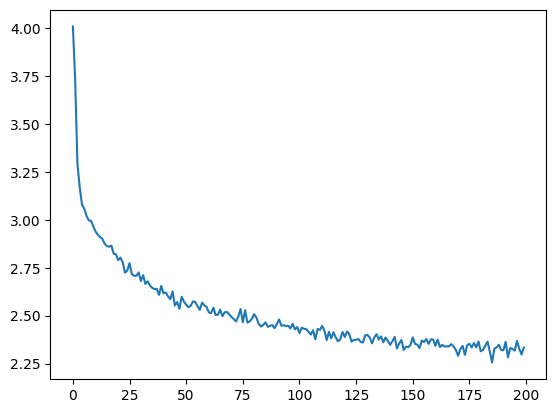

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Muestreo de la red
Para muestrear damos a la red una letra y preguntamos cuál es la siguiente, introducimos esa como la siguiente letra, y repetimos hasta el token EOS.

* Creamos tensores para la categoría de entrada, la letra inicial y el estado oculto vacío vacío

* Crea una cadena nombre_de_salida con la letra inicial

* Hasta una longitud máxima de salida,

  * Alimentar la letra actual a la red
  
  * Obtiene la siguiente letra de la salida más alta, y el siguiente estado oculto

  * Si la letra es EOS, parar aquí
  * Si es una letra normal, añadir a nombre_salida y continuar

Devuelve el nombre final

.. Nota:: En lugar de tener que darle una letra inicial, otra estrategia habría sido incluir un token de "inicio de cadena" en el entrenamiento y que la red eligiera su propia letra inicial.


In [26]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian')
samples('German')
samples('Spanish')
samples('Chinese')

Allan
Barino
Chanak
Alen
Berten
Chare
Allana
Bara
Cara
Ang
Ban
Chani


## Ejercicios

* Pruebe con un conjunto de datos diferente de categoría (Esta sección será la calificación de la práctica utilice cualquiera ejemplo que desea o de los planteados a continuación) -> línea, por ejemplo:

  * Serie de ficción -> Nombre del personaje
  * Parte de la oración -> Palabra
  * País -> Ciudad

A continuación se eligio un dataset sobre los lugares donde se grabaron y se rodaron algunas series, el cual se grabo.

Bueno el archivo se llama data1, y los datos se encuentran dentro de la carpeta lugares_serie_ficcion.


In [42]:
!unzip data1.zip

Archive:  data1.zip
   creating: data1/
  inflating: data1/eng-fra.txt       
   creating: data1/lugares_serie_ficcion/
  inflating: data1/lugares_serie_ficcion/Better_Call_Saul.txt  
  inflating: data1/lugares_serie_ficcion/Black_Mirror.txt  
  inflating: data1/lugares_serie_ficcion/Breaking_Bad.txt  
  inflating: data1/lugares_serie_ficcion/Chicago_Fire.txt  
  inflating: data1/lugares_serie_ficcion/Cobra_Kai.txt  
  inflating: data1/lugares_serie_ficcion/Game_of_Thrones.txt  
  inflating: data1/lugares_serie_ficcion/Good_Wife.txt  
  inflating: data1/lugares_serie_ficcion/House_of_Cards.txt  
  inflating: data1/lugares_serie_ficcion/How_I_Met_Your_Mother.txt  
  inflating: data1/lugares_serie_ficcion/Mad_Men.txt  
  inflating: data1/lugares_serie_ficcion/Motel_Bates.txt  
  inflating: data1/lugares_serie_ficcion/Narcos.txt  
  inflating: data1/lugares_serie_ficcion/Person_of_Interest.txt  
  inflating: data1/lugares_serie_ficcion/The_Last_Of_Us.txt  
  inflating: data1/lugares_serie

In [43]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path):
  return glob.glob(path)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]


# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data1/lugares_serie_ficcion/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')


print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 17 ['House_of_Cards', 'How_I_Met_Your_Mother', 'Chicago_Fire', 'Mad_Men', 'Better_Call_Saul', 'The_Sopranos', 'Narcos', 'The_Last_Of_Us', 'Person_of_Interest', 'Good_Wife', 'Black_Mirror', 'The_Walking_Dead', 'Game_of_Thrones', 'Motel_Bates', 'Breaking_Bad', 'Cobra_Kai', 'Vikingos']
O'Neal


In [44]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size


        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [45]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [46]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [47]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [48]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)


    return output, loss.item() / input_line_tensor.size(0)

In [50]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [51]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 24s (5000 5%) 2.5283
0m 48s (10000 10%) 2.7042
1m 12s (15000 15%) 2.4313
1m 37s (20000 20%) 2.7961
2m 1s (25000 25%) 2.4082
2m 26s (30000 30%) 2.0208
2m 52s (35000 35%) 2.7055
3m 17s (40000 40%) 1.5840
3m 42s (45000 45%) 2.3593
4m 7s (50000 50%) 1.7366
4m 32s (55000 55%) 1.9045
4m 57s (60000 60%) 1.6073
5m 21s (65000 65%) 1.7293
5m 46s (70000 70%) 1.4852
6m 11s (75000 75%) 0.8832
6m 35s (80000 80%) 1.0905
7m 0s (85000 85%) 1.2185
7m 24s (90000 90%) 0.7284
7m 48s (95000 95%) 1.0359
8m 12s (100000 100%) 0.7319


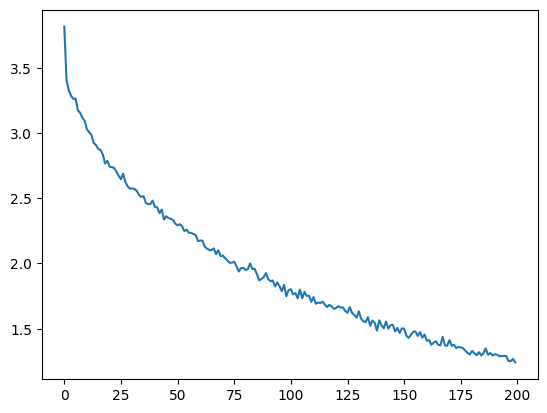

In [52]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(all_losses)

In [53]:
max_length = 20


# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()


        output_name = start_letter


        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        return output_name


# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

"""
A continuacion se va a probar la funcionalidad del entrenamiento,
mediante el ingreso de lugares donde se grabaron algunas de las
series puestas en el dataset.

"""

In [59]:

#Aqui se prueba con las categorias ingresadas
samples('Better_Call_Saul')
samples('Breaking_Bad')
samples('Game_of_Thrones')
samples('The_Walking_Dead')
samples('Chicago_Fire')
samples('Mad_Men')
samples('Motel_Bates')

Ald Mushut os Aeralal
Bay Sarket
Chitta de Wist Rutre
Albaqueruacior oniman
Batak anica do Dortos
Cata dranksat ominter
Antallsa de Sanse, or
Batoanada Fartater
Chitan Re Maracena ds
Ath Tucoutey
Batumia
Chringo
Are Besh Aredem Parku
Bagdingh Piak
Chicago di pewazkia
Allantarion Sat Hick 
Bondengot Dring
Chiteriat Mackweor
Areven
Brich Cond or ;soru
Chitarin Maneavarie
